In [14]:
from Utils import *
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import pickle
import time
import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.ensemble import RandomForestClassifier
# from sklearn.decomposition import PCA

In [15]:
data_set, Y = readDataSet()

In [16]:
X_train, X_testValid, Y_train, Y_testValid = train_test_split(data_set, Y, test_size=0.2, random_state=60)  

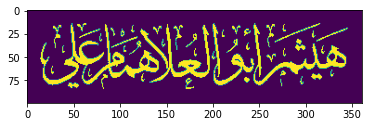

In [17]:
# visulaize dataset after training
import matplotlib.pyplot as plt
from random import seed
from random import randint
# seed random number generator
i = randint(0, len(X_train) -1)
plt.imshow(X_train[i])

In [18]:
# some constants
subset_size = 60000 # subset size choosen out of local features for kmeans clustering
no_clusters = 512 # number of codes in generated codebook (parameter for kmeans)
no_descriptors = 150 # maximum number of descriptors extracted by SIFT
b_size = 4096 # batch_size for MiniBatch Kmeans

In [19]:
def getDescriptors(img):
    sift = cv2.SIFT_create(no_descriptors)
    kp, des = sift.detectAndCompute(img, None)
    return des

In [20]:
def vstackDescriptors(descriptor_list):
    descriptors = np.array(descriptor_list[0])
    for descriptor in descriptor_list[1:]:
        descriptors = np.vstack((descriptors, descriptor))
    return descriptors

In [21]:
def clusterDescriptors(descriptors, no_clusters):
    start_time = time.time()
#     kmeans = KMeans(n_clusters = no_clusters).fit(descriptors)
    kmeans = MiniBatchKMeans(n_clusters= no_clusters, batch_size=b_size).fit(descriptors)
    end_time = time.time()
    print("time elapsed for computing Kmeans : ", end_time - start_time)
    return kmeans

In [22]:
def generate_codebook(subset_size=40000, no_clusters=1024):
    start_time = time.time()
    descriptor_list = []
    image_count = len(X_train)
    for img in X_train:
        des = np.array(getDescriptors(img))
        if len(descriptor_list) == 0 :
            descriptors = des
        else:
            descriptors = np.vstack((descriptors, des))
        descriptor_list.append(des)
        
#     descriptors = vstackDescriptors(descriptor_list)
    print("descriptors shape before selecting a subset : ", descriptors.shape)
    # select a number of descriptors at random to train the KMeans classifier to get the codes
    number_of_rows = descriptors.shape[0]
    random_indices = np.random.choice(number_of_rows, size=subset_size, replace=False)
    descriptors = descriptors[random_indices, :]
    # reduce the dimensionality of the selected keypoints using pca
#     pca = PCA(n_components=64)
#     descriptors = pca.fit_transform(descriptors)
    print("descriptors shape after selecting a subset: ", descriptors.shape)
    codes = clusterDescriptors(descriptors, no_clusters)
    end_time = time.time()
    print("time taken to generate codebook : " , end_time - start_time)
    return codes, descriptor_list
    

In [23]:
codes, dlist  = generate_codebook(subset_size, no_clusters)


descriptors shape before selecting a subset :  (170087, 128)
descriptors shape after selecting a subset:  (60000, 128)
time elapsed for computing Kmeans :  19.09986424446106
time taken to generate codebook :  56.35384798049927


In [24]:
# Extract features
def extractFeatures(kmeans, descriptor_list, image_count, no_clusters):
    im_features = np.array([np.zeros(no_clusters) for i in range(image_count)])
    for i in range(image_count):
        idx = kmeans.predict(descriptor_list[i])
        uniqueValues, occurCount = np.unique(idx, return_counts=True)
        im_features[i][uniqueValues] = occurCount 
#     print("features before normalization : ", im_features)   
    scale = StandardScaler().fit(im_features)        
    im_features = scale.transform(im_features)
#     print("features after normalization : ", im_features)
    print("features normalized.")

    return im_features

In [25]:
im_features = extractFeatures(codes, dlist, len(X_train), no_clusters)

features normalized.


In [26]:
# extract lpq features for training data
start_time = time.time()
lpq_train = []
for i in range(len(X_train)):
    lpq_train.append(lpq(X_train[i]))
end_time = time.time()
print("time taken for lpq feature extraction : ", end_time - start_time)
# extract lpq features for test data
lpq_test = []
for i in range(len(X_testValid)):
    lpq_test.append(lpq(X_testValid[i]))

time taken for lpq feature extraction :  22.739999055862427


In [27]:
# get descriptors for test set
dlist_test = []
for img in X_testValid:
    des = getDescriptors(img)
    dlist_test.append(des)
im_features_test = extractFeatures(codes, dlist_test, len(X_testValid), no_clusters)
print(im_features_test.shape)

features normalized.
(337, 512)


In [28]:
# concatenate lpq and BoVW
im_features_conc = np.concatenate((im_features, lpq_train), axis = 1 )
im_features_test_conc = np.concatenate((im_features_test, lpq_test), axis = 1 )
print(im_features_conc.shape)
print(im_features_test_conc.shape)

(1348, 767)
(337, 767)


In [16]:
# # apply KNN
# from sklearn.neighbors import KNeighborsClassifier
# neigh = KNeighborsClassifier(n_neighbors=5)
# neigh.fit(im_features, Y_train)

# # testingg
# answers = []
# y_pred = neigh.predict(im_features_test)

In [29]:
# test with BoVW only
X = np.array(im_features)
y = np.array(Y_train)
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X, y)
# predict the test data
y_pred_BoVW = (clf.predict(im_features_test))

In [30]:
# test with BoVW only
X = np.array(lpq_train)
y = np.array(Y_train)
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X, y)
# predict the test data
y_pred_lpq = (clf.predict(lpq_test))

In [31]:
# test concatenated BoVW + LPQ
X = np.array(im_features_conc)
y = np.array(Y_train)
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X, y)
# predict the test data
y_pred_conc = (clf.predict(im_features_test_conc))

In [32]:
# calculate accuracy for concatenated BoVW + LPQ
acc_BoVW = np.mean(y_pred_BoVW == Y_testValid) * 100
acc_lpq = np.mean(y_pred_lpq == Y_testValid) * 100
acc_conc = np.mean(y_pred_conc == Y_testValid) * 100
print("acc_BoVW : ", acc_BoVW, "%")
print("acc_lpq : ", acc_lpq, "%")
print("acc_conc : ", acc_conc, "%")

acc_BoVW :  96.14243323442136 %
acc_lpq :  95.54896142433235 %
acc_conc :  97.92284866468842 %


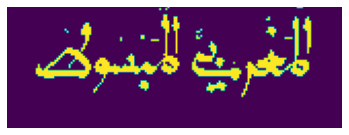

Actual class : maghribi
predicted_class :  mohakek
---------------------------------------


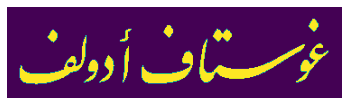

Actual class : parsi
predicted_class :  rekaa
---------------------------------------


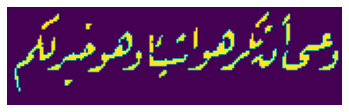

Actual class : rekaa
predicted_class :  parsi
---------------------------------------


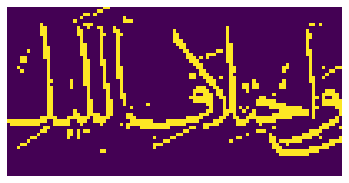

Actual class : mohakek
predicted_class :  thuluth
---------------------------------------


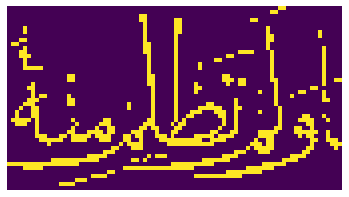

Actual class : mohakek
predicted_class :  thuluth
---------------------------------------


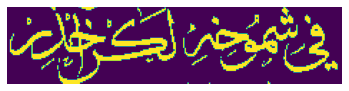

Actual class : thuluth
predicted_class :  mohakek
---------------------------------------


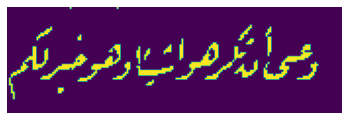

Actual class : rekaa
predicted_class :  parsi
---------------------------------------


In [33]:
classes = ["diwani", "naskh", "parsi", "rekaa", "thuluth", "maghribi", "kufi", "mohakek", "Squar-kufic"]

# show wrongly classified examples
for i in range(len(X_testValid)):
    if(y_pred_conc[i] != Y_testValid[i]):
        # Visualize each test figure. 
        fig = plt.figure()
        plt.imshow(X_testValid[i])
        plt.axis("off")
        plt.show()

        # Print the actual class of each test figure. 
        print("Actual class :", classes[Y_testValid[i]])
        print("predicted_class : ", classes[y_pred_conc[i]])
        print("---------------------------------------")

In [34]:
# random forest
X = np.array(im_features_conc)
y = np.array(Y_train)

clf = RandomForestClassifier(random_state=12)
clf.fit(X, y)
y_pred = (clf.predict(im_features_test_conc))
#print(Y_validation)
acc = np.mean(y_pred == Y_testValid) * 100
print(acc)

97.92284866468842
